In [1]:
%load_ext autoreload
%autoreload 2

In [195]:
import pyodbc
import pandas as pd  # sure takes a long time
import dizzy_util as util
import eval_util
import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
import cluster_umap
from collections import defaultdict


In [3]:
dataset = util.extractDataset("B00", {"Notes", "AllMed", "Vital", "HF", "DispensedDrug"})

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_Demorgraphics,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_12_ICD,BASE TABLE


dict_keys(['cohort', 'Demorgraphics', 'Lab', 'Rad', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD', 'Note', 'WithRole'])


In [4]:
dizziness_df, label_map =util.retrieveLabels()

,DxErrorER,DxErrorERCoded
0,3,MOD
1,3,MOD
2,2,PMOD
3,1,NoMOD
4,3,MOD
...,...,...
95,3,MOD
96,2,PMOD
97,1,NoMOD
98,1,NoMOD


In [5]:
dizziness_df["DxErrorERCoded"].value_counts()

NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: DxErrorERCoded, dtype: Int64

In [6]:
label_df = util.convertLabelMap(label_map)

In [7]:
dizziness_df.DxErrorERCoded.astype("string").unique()

<StringArray>
['MOD', 'PMOD', 'NoMOD', 'CodingEr']
Length: 4, dtype: string

In [8]:
dizziness_df.columns

Index(['ID', 'StudyID', 'ReviewerID', 'NewStudyID',
       'Trigger positive/Negative', 'DxErrorER', 'DxErrorERCoded',
       'ReviewDate', 'PtSSN', 'Facility',
       ...
       'DimPatientOther', 'DimPtProvider', 'DimPtProviderOther',
       'DimDiagnosticTests', 'DimDiagnosticTestsOther', 'DimFollowTracking',
       'DimFollowTrackingOther', 'DimReferrals', 'DimReferralsOther',
       'CaseSummaryER'],
      dtype='object', length=105)

In [9]:
dizziness_df.dropna(subset=["DxErrorER", "PtSSN"], inplace=True)
display(dizziness_df[["DxErrorER", "DxErrorERCoded"]])


,DxErrorER,DxErrorERCoded
0,3,MOD
1,3,MOD
2,2,PMOD
3,1,NoMOD
4,3,MOD
...,...,...
95,3,MOD
96,2,PMOD
97,1,NoMOD
98,1,NoMOD


In [10]:
datasubset = util.extractAndStandarizeCohort(dataset, "Dizziness")

In [ ]:
display(datasubset["cohort"])

In [12]:
icd_df = datasubset["ICD"]

In [ ]:
display(icd_df)

In [14]:
edstart = util.extractFirstVisitIndexDatetime(datasubset["cohort"])

In [15]:
filtered_icd_df = util.filterDFByTimes(icd_df, util.ICD_PATIENT_ID, "DiagDateTime", edstart)

In [ ]:
display(filtered_icd_df)

In [ ]:
icd_features = util.makeICDFeatures(filtered_icd_df)
display(icd_features.norm_vec)

In [18]:
util.getICDCodes()["Smoking"]

['305.1',
 '305.1',
 '305.11',
 '305.12',
 '305.13',
 '649.0',
 '649.01',
 '649.02',
 '649.03',
 '649.04',
 'F17.200',
 'F17.203',
 'F17.208',
 'F17.209',
 'F17.210',
 'F17.213',
 'F17.218',
 'F17.219',
 'F17.220',
 'F17.223',
 'F17.228',
 'F17.229',
 'F17.290',
 'F17.293',
 'F17.298',
 'F17.299',
 'O99.330',
 'O99.331',
 'O99.332',
 'O99.333',
 'O99.334',
 'O99.335']

In [ ]:
# validate icd calculations
test_df = filtered_icd_df[filtered_icd_df.PatientSSN == 000000000000]
util.displayAll(test_df[test_df.ICD.str.contains("F17", case=False)])
util.displayAll(test_df[test_df.ICD.str.contains("O99", case=False)])

In [ ]:
outpat_df = datasubset["RxOutpat"]
filtered_outpat_df = util.filterDFByTimes(outpat_df, util.DRUG_PATIENT_ID, "DispensedDate", edstart)
outpat_features = util.makeRxOutpatFeatureVector(filtered_outpat_df)
display(outpat_features)

In [ ]:
outpat_features = util.makeOutpatWindowFeatures(filtered_outpat_df, edstart)
display(outpat_features.norm_vec)

In [ ]:
util.makeRxOutpatTimeWindowVec(filtered_outpat_df, edstart)

In [23]:
util.getDrugCodesBySuperCategory()["cholesterol"]

['CV350']

In [ ]:
# validate results of window
test_df = filtered_outpat_df[filtered_outpat_df.PatientSSN == 000000000000000]
display(datasubset["cohort"][datasubset["cohort"].patientSSN == 000000000000000])
display(test_df)

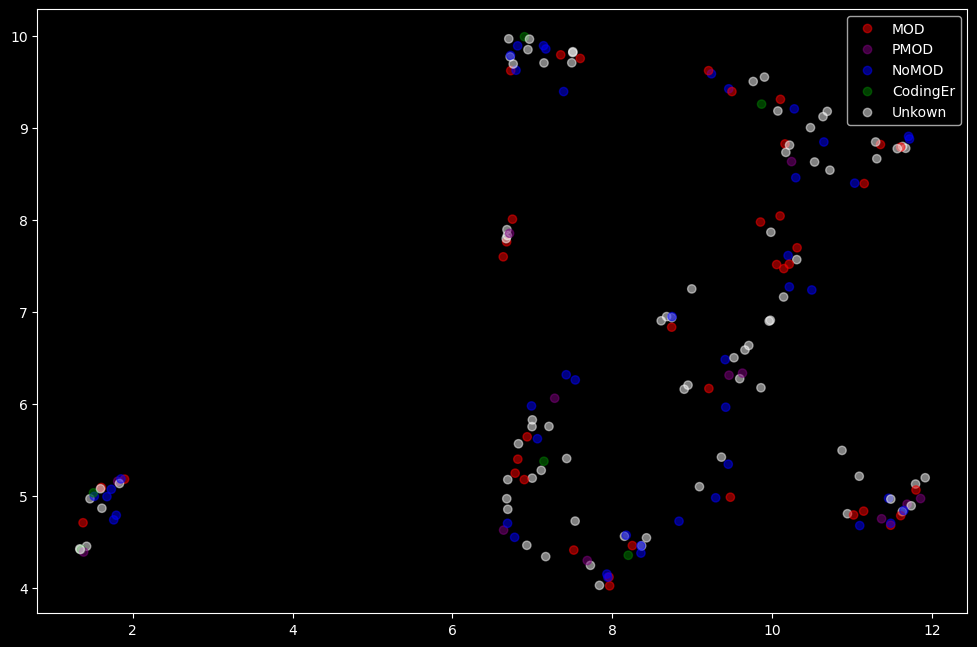

In [45]:
feature_vec4 = util.mergeFeatures([icd_features, outpat_features])
reducer4 = umap.UMAP(metric="correlation", min_dist=0)
embedding4 = util.UMAPPlot(reducer4, feature_vec4, label_map)

In [ ]:
# cluster_umap.run_clustering_on_umap(embedding4, 5, feature_vec4.iloc[:,1:], feature_vec4.columns[1:])
cluster_umap.run_clustering_on_umap(embedding4, 5, feature_vec4, util.convertLabelMap(label_map))

In [54]:
outpat_features.iloc[:,1:] /= 180

AttributeError: 'OutpatFeature' object has no attribute 'iloc'

In [55]:
display(outpat_features)

In [56]:
icd_capped = icd_features.copy()
icd_capped.iloc[:,1:] = icd_capped.iloc[:,1:].clip(upper=5)
display(icd_capped)

AttributeError: 'ICDFeature' object has no attribute 'copy'

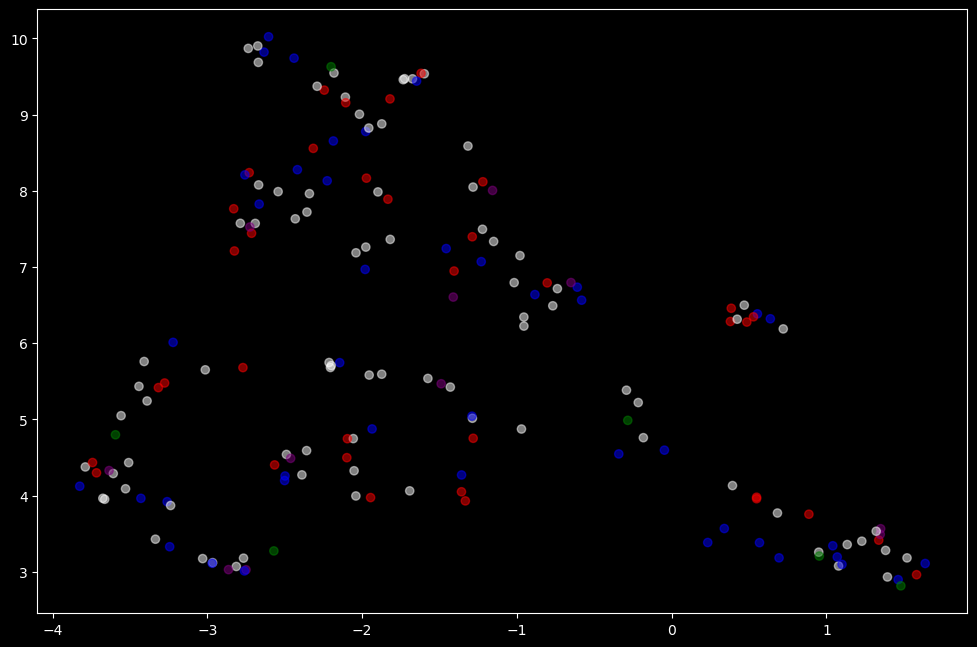

In [35]:
feature_vec2 = outpat_features.merge(icd_capped, how="outer", left_on=util.ICD_PATIENT_ID, right_on=util.DRUG_PATIENT_ID)
feature_vec2 = feature_vec2.fillna(0)
reducer2 = umap.UMAP(metric="correlation", min_dist=0)
embedding2 = util.UMAPscalePlot(reducer2, feature_vec2, label_map)

# Procedural

In [36]:
consult_feature = util.makeConsultFeature(datasubset["Consult"], edstart)
consult_vec = consult_feature.norm_vec

In [ ]:
display(consult_vec)

In [27]:
consult_vec[consult_vec.HasConsult > 1]

,HasConsult
PatientSSN,


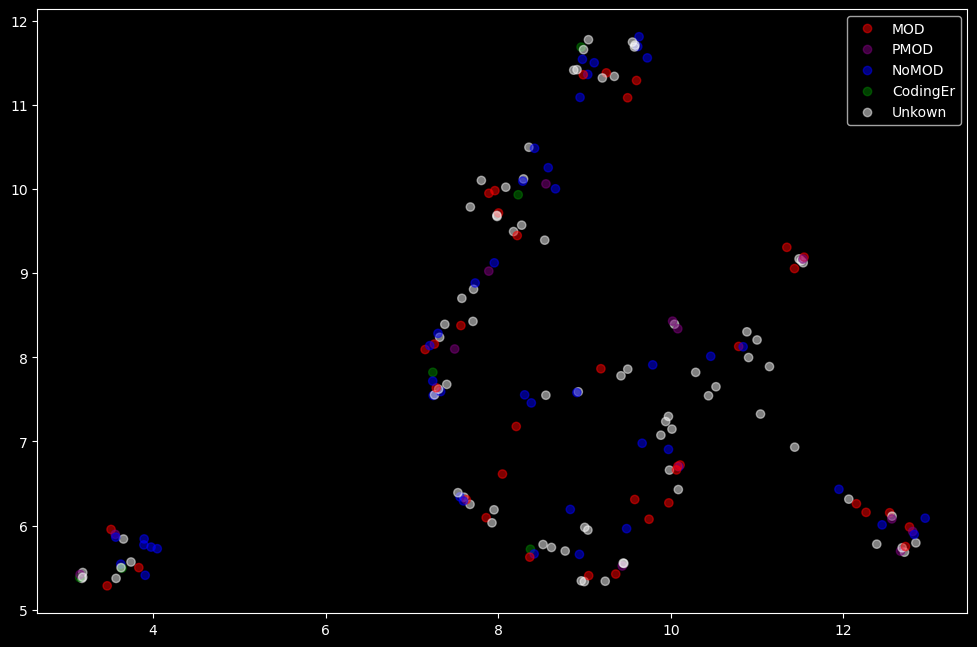

In [60]:
feature_vec5 = util.mergeFeatures([icd_features, outpat_features, consult_feature])

reducer5 = umap.UMAP(metric="correlation", min_dist=0)
embedding5 = util.UMAPPlot(reducer5, feature_vec5, label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding5, 7, feature_vec5, label_df)

In [37]:
rad_feature = util.makeRadFeature(datasubset["Rad"], edstart)
rad_vec = rad_feature.norm_vec

In [ ]:
util.displayAll(rad_vec)

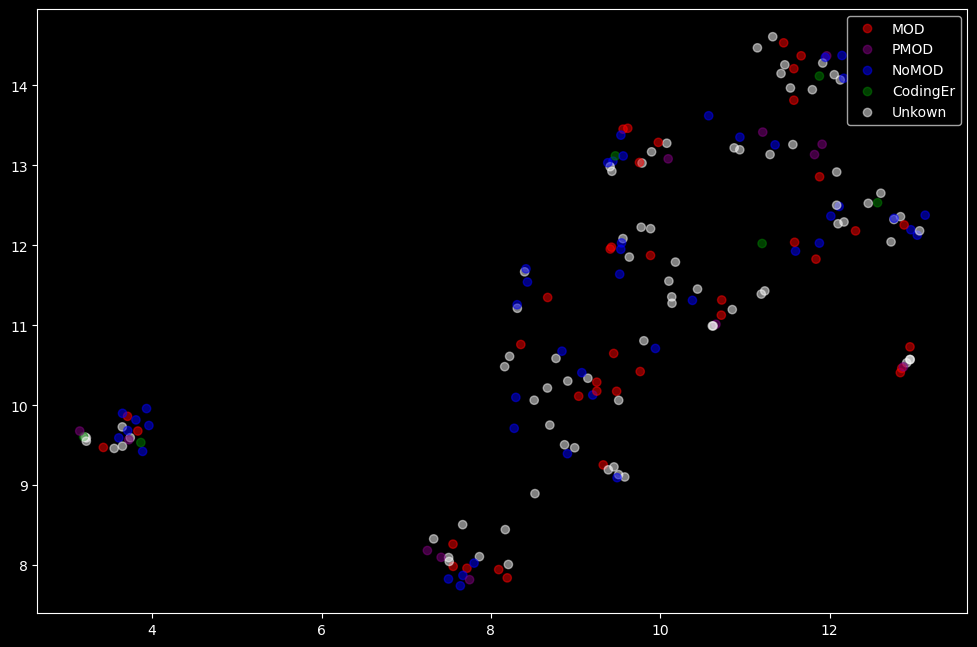

In [66]:
feature_vec6 = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature])


reducer6 = umap.UMAP(metric="correlation", min_dist=0)
embedding6 = util.UMAPPlot(reducer6, feature_vec6, label_map)

In [ ]:
display(feature_vec6)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding6, 8, feature_vec6, label_df)

In [29]:
holidays = util.makeHolidayVec(edstart)
holidays[holidays["Holiday"] != 0]

,PatientSSN,IndexDate,Holiday


In [38]:
weekend_feature = util.makeWeekendFeature(edstart)

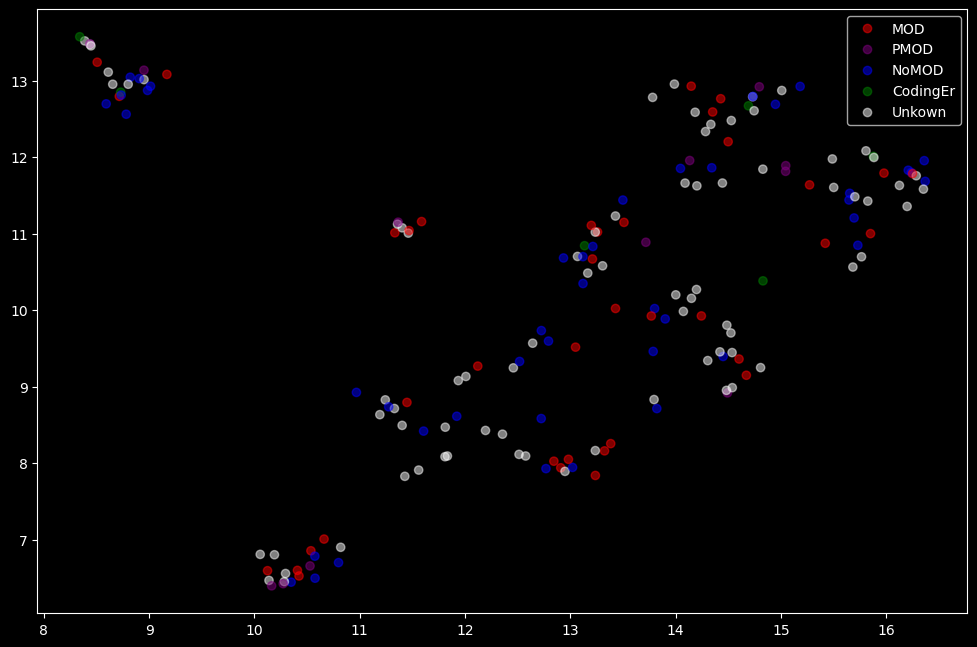

In [70]:

feature_vec9 = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature])
reducer9 = umap.UMAP(metric="correlation", min_dist=0)
embedding9 = util.UMAPPlot(reducer9, feature_vec9, label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding9, 8, feature_vec9, label_df)

In [165]:
demo_df = datasubset["Demorgraphics"]
age_feature = util.makeAgeFeature(demo_df)
cohort_df = datasubset["cohort"]
index_feature = util.makeIndexFeature(cohort_df)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


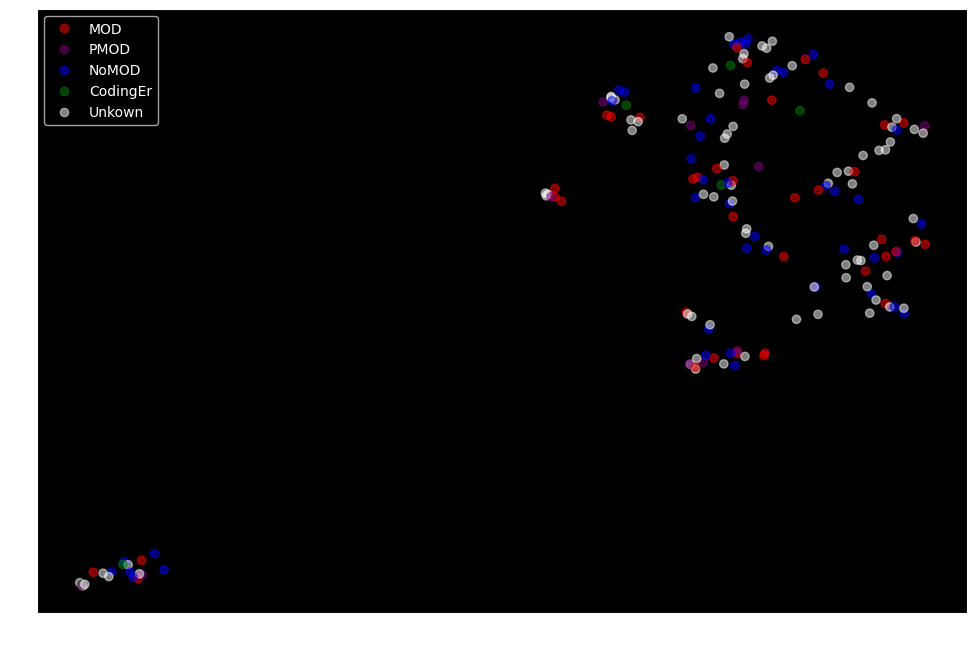

In [166]:
feature_vec10 = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, age_feature, index_feature])
reducer10 = umap.UMAP(metric="correlation", min_dist=0)
embedding10 = util.UMAPPlot(reducer10, feature_vec10, label_map)

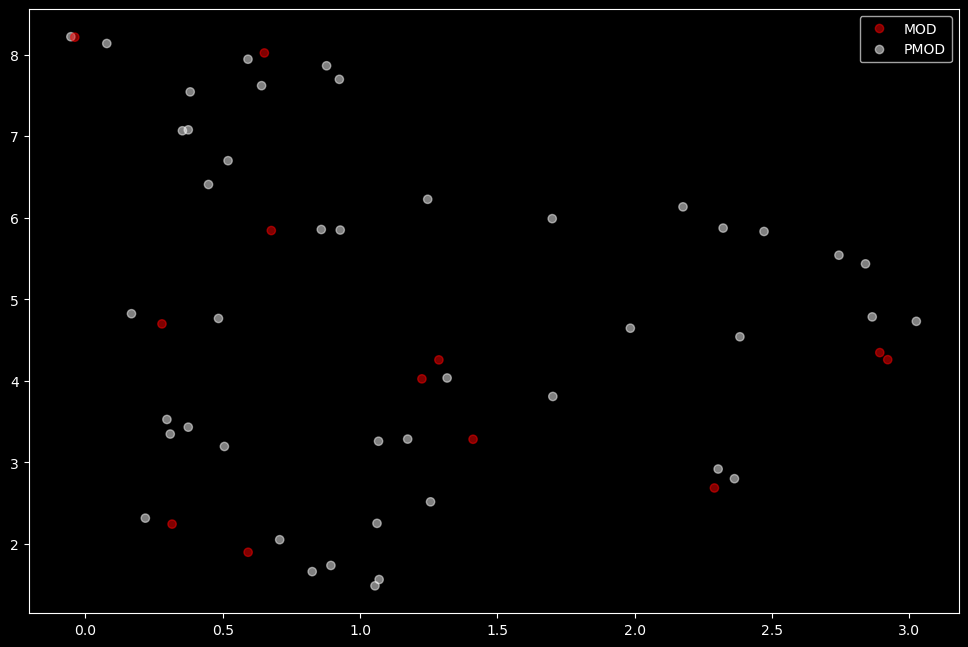

In [232]:
from matplotlib.colors import ListedColormap

feature_vec11 = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, age_feature, index_feature])
reducer11 = umap.UMAP(metric="euclidean", min_dist=0, n_neighbors=5)

feature_vec11 = feature_vec11.merge(label_df[(label_df.Label == "NoMOD") | (label_df.Label == "PMOD")])
embedding11 = reducer11.fit_transform(feature_vec11.iloc[:,1:-1])

classes = ["MOD", "PMOD", "NoMOD", "CodingEr", "Unkown"]
color_map = ["red", "red", "blue", "green", "white"]
class_map = {"MOD": 0, "PMOD": 1, "NoMOD": 2, "CodingEr": 3, "Unkown": 4}
colors = [ class_map[label_map[id]] if id in label_map else 4 for id in feature_vec11.PatientSSN]
fig = plt.figure(figsize=(12,8), dpi=100)
plt.style.use("dark_background")
scatter = plt.scatter(embedding11[:, 0], embedding11[:, 1], c=colors, cmap=ListedColormap(color_map), alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [ ]:
cluster_umap.run_clustering_on_umap(embedding10, 8, feature_vec10, label_df)

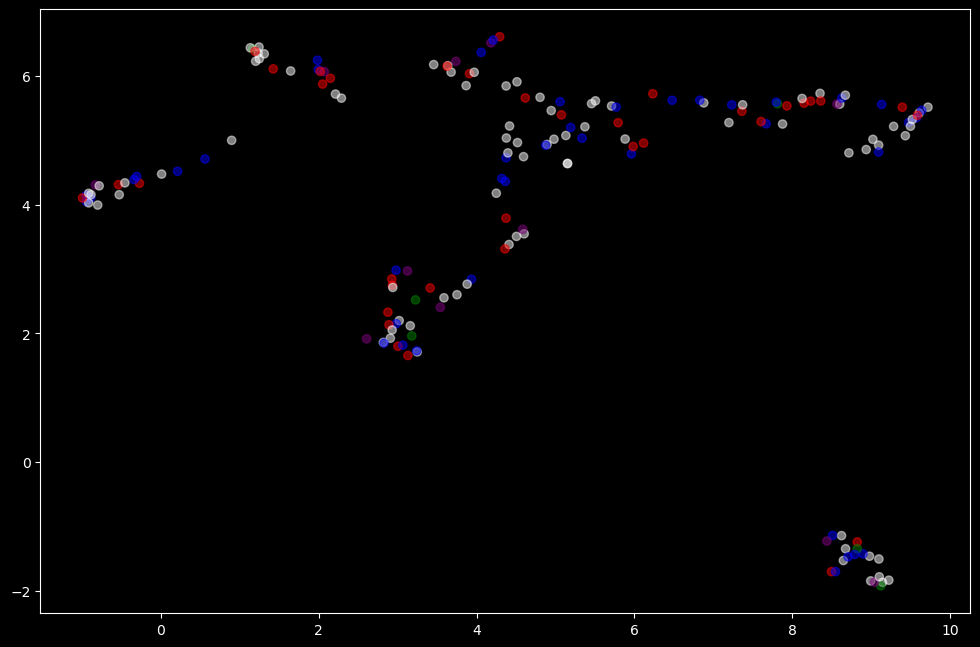

In [50]:
reducer7 = umap.UMAP(metric="cosine", min_dist=0)
embedding7 = util.UMAPscalePlot(reducer7, feature_vec6, label_map)

# Evaluation

In [43]:
# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier

In [44]:
# seed
RANDOM_STATE_SEED = 42
# train-test-split test size
TEST_SIZE = 0.15
# logistic regression model constants
LOGISTIC_REGRESSION_ITER = 10000

In [ ]:
feature_vec = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, 
                                  age_feature, index_feature], normalize=True)
display(feature_vec)

In [235]:
label_df2 = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "PMOD")]

In [236]:
# labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec, label_df)
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec, label_df2)


In [ ]:
display(labeled_df)

In [283]:
import logreg
# define space of model's parameter values
hyperparameter_grid_log = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-1, 4, 10),
    'solver': ['liblinear','saga']
}

best_model_logensemble = eval_util.runGridSearch(
    logreg.UnbalancedLogisticEnsemble(10, max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced'), 
    hyperparameter_grid_log, 
    labeled_df, 
    X_cols, 
    y_col)

Best penalty: l1
Best C: 0.1
Best solver: liblinear
[[5 0]
 [4 0]]
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71         5
         1.0       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

[[39  0]
 [ 8  0]]
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        39
         1.0       0.00      0.00      0.00         8

    accuracy                           0.83        47
   macro avg       0.41      0.50      0.45        47
weighted avg       0.69      0.83      0.75        47



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [287]:
est = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight={0:(8/47), 1:(39/47)})
eval_util.runGridSearch(
    est,
    hyperparameter_grid_log, 
    labeled_df, 
    X_cols, 
    y_col)

Best penalty: l1
Best C: 1e-10
Best solver: liblinear
[[5 0]
 [4 0]]
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71         5
         1.0       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

[[39  0]
 [ 8  0]]
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        39
         1.0       0.00      0.00      0.00         8

    accuracy                           0.83        47
   macro avg       0.41      0.50      0.45        47
weighted avg       0.69      0.83      0.75        47



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.1702127659574468,
                                                        1: 0.8297872340425532},
                                          max_iter=10000, random_state=42),
             n_jobs=1,
             param_grid={'C': array([1.00000000e-10, 3.59381366e-09, 1.29154967e-07, 4.64158883e-06,
       1.66810054e-04, 5.99484250e-03, 2.15443469e-01, 7.74263683e+00,
       2.78255940e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

Best Penalty: l1
Best C: 1e-10
Best Solver: liblinear
[[5 0]
 [4 0]]
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71         5
         1.0       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

[[39  0]
 [ 8  0]]
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        39
         1.0       0.00      0.00      0.00         8

    accuracy                           0.83        47
   macro avg       0.41      0.50      0.45        47
weighted avg       0.69      0.83      0.75        47



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


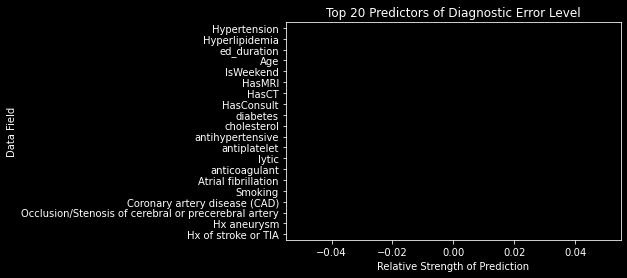

In [285]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-10, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogReg(hyperparameter_grid_log, labeled_df, X_cols, y_col)

Best Number of Estimators: 2
Best Depth: 3
[[1 7]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.33      0.12      0.18         8
         1.0       0.42      0.71      0.53         7

    accuracy                           0.40        15
   macro avg       0.38      0.42      0.35        15
weighted avg       0.37      0.40      0.34        15

[[26 10]
 [ 5 38]]
              precision    recall  f1-score   support

         0.0       0.84      0.72      0.78        36
         1.0       0.79      0.88      0.84        43

    accuracy                           0.81        79
   macro avg       0.82      0.80      0.81        79
weighted avg       0.81      0.81      0.81        79



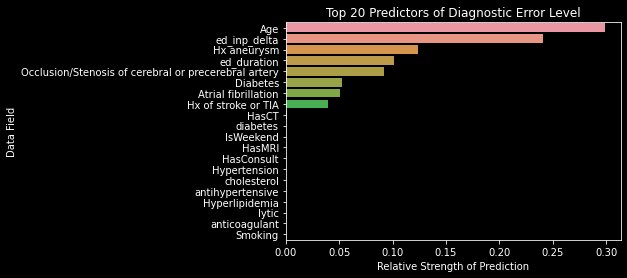

In [186]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForest(hyperparameter_grid_rf, labeled_df, X_cols, y_col)

In [ ]:
orig_vec = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, 
                                  age_feature, index_feature], normalize=False)
display(orig_vec)

In [188]:
olabeled_df, ounlabeled_df, oX_cols, oy_col = util.makeDataset(orig_vec, label_df)

In [ ]:
label_df

In [220]:
temp_labeled_df = orig_vec.merge(label_df, how="inner", left_on="PatientSSN", right_on="PatientSSN")

In [ ]:
temp_labeled_df[temp_labeled_df["Label"] == "PMOD"].describe().T

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "NoMOD"])

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "PMOD"])

In [216]:
test_consult_feature = util.makeConsultFeature(datasubset["Consult"], edstart, 12)
test_rad_feature = util.makeRadFeature(datasubset["Rad"], edstart, 12)

In [ ]:
orig_vec = util.mergeFeatures([icd_features, outpat_features, test_consult_feature, test_rad_feature, weekend_feature, 
                                  age_feature, index_feature], normalize=False)
temp_labeled_df = orig_vec.merge(label_df, how="inner", left_on="PatientSSN", right_on="PatientSSN")
display(temp_labeled_df[temp_labeled_df["Label"] == "PMOD"])
display(temp_labeled_df[temp_labeled_df["Label"] == "MOD"])

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "NoMOD"])

Best Penalty: l2
Best C: 4.641588833612779
Best Solver: liblinear
[[4 4]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.56      0.71      0.63         7

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.61      0.60      0.60        15

[[26 10]
 [11 32]]
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71        36
         1.0       0.76      0.74      0.75        43

    accuracy                           0.73        79
   macro avg       0.73      0.73      0.73        79
weighted avg       0.73      0.73      0.73        79



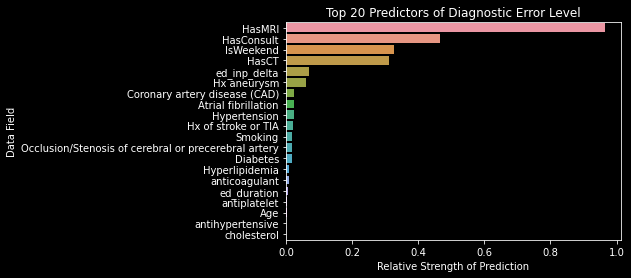

In [191]:
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

obest_model_log = eval_util.runLogReg(hyperparameter_grid_log, olabeled_df, oX_cols, oy_col)

Best Number of Estimators: 10
Best Depth: 2
[[3 5]
 [4 3]]
              precision    recall  f1-score   support

         0.0       0.43      0.38      0.40         8
         1.0       0.38      0.43      0.40         7

    accuracy                           0.40        15
   macro avg       0.40      0.40      0.40        15
weighted avg       0.40      0.40      0.40        15

[[32  4]
 [ 6 37]]
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        36
         1.0       0.90      0.86      0.88        43

    accuracy                           0.87        79
   macro avg       0.87      0.87      0.87        79
weighted avg       0.87      0.87      0.87        79



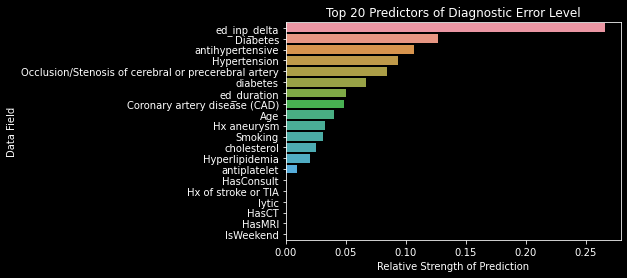

In [192]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForest(hyperparameter_grid_rf, olabeled_df, oX_cols, oy_col)

In [ ]:
n_age_feature = util.makeAgeFeature(demo_df, False)
n_index_feature = util.makeIndexFeature(cohort_df, False)
n_feature_vec = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, 
                                  n_age_feature, n_index_feature], normalize=True)
display(n_feature_vec)

In [203]:
nlabeled_df, nunlabeled_df, nX_cols, ny_col = util.makeDataset(n_feature_vec, label_df)

Best Penalty: l1
Best C: 0.35938136638046275
Best Solver: liblinear
[[3 5]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.50      0.71      0.59         7

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

[[15 21]
 [ 6 37]]
              precision    recall  f1-score   support

         0.0       0.71      0.42      0.53        36
         1.0       0.64      0.86      0.73        43

    accuracy                           0.66        79
   macro avg       0.68      0.64      0.63        79
weighted avg       0.67      0.66      0.64        79



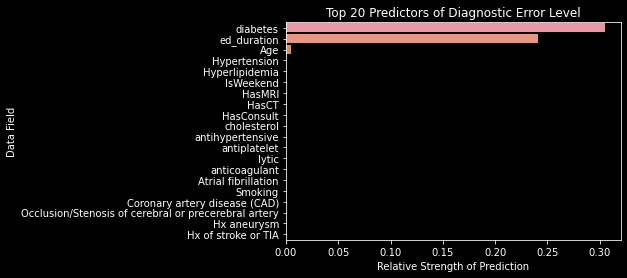

In [204]:
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

nbest_model_log = eval_util.runLogReg(hyperparameter_grid_log, nlabeled_df, nX_cols, ny_col)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

In [104]:
estimator_log = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [113]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

In [114]:
# determine best parameters to fit model ti training data
grid_search_log = GridSearchCV(
    estimator = estimator_log
    ,param_grid = hyperparameter_grid_log
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

best_model_log = grid_search_log.fit(X_train, y_train)

In [115]:
# print best parameters
print('Best Penalty:', best_model_log.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_log.best_estimator_.get_params()['C'])
print('Best Solver:', best_model_log.best_estimator_.get_params()['solver'])
print('Best Multi-Class:', best_model_log.best_estimator_.get_params()['multi_class'])
print('Best Fit Intercept:', best_model_log.best_estimator_.get_params()['fit_intercept'])

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True


In [124]:
def eval_model(model, X, y):
    predictions = model.predict(X)
    print(metrics.confusion_matrix(y, predictions))
    print(metrics.classification_report(y, predictions))

In [117]:
eval_model(best_model_log, X_test, y_test)
eval_model(best_model_log, X_train, y_train)

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True
[[8 0]
 [7 0]]
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70         8
         1.0       0.00      0.00      0.00         7

    accuracy                           0.53        15
   macro avg       0.27      0.50      0.35        15
weighted avg       0.28      0.53      0.37        15

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True
[[36  0]
 [43  0]]
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        36
         1.0       0.00      0.00      0.00        43

    accuracy                           0.46        79
   macro avg       0.23      0.50      0.31        79
weighted avg       0.21      0.46      0.29        79



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
# create a random forest model
estimator_rf = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [127]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [1, 2, 3, 4, 5]
}

In [128]:
# determine best parameters to fit model to training data
grid_search_rf = GridSearchCV(
    estimator = estimator_rf
    ,param_grid = hyperparameter_grid_rf
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

best_model_rf = grid_search_rf.fit(X_train, y_train)

In [129]:
eval_model(best_model_rf, X_test, y_test)
eval_model(best_model_rf, X_train, y_train)

[[3 5]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.50      0.71      0.59         7

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

[[28  8]
 [ 5 38]]
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81        36
         1.0       0.83      0.88      0.85        43

    accuracy                           0.84        79
   macro avg       0.84      0.83      0.83        79
weighted avg       0.84      0.84      0.83        79



In [130]:
print('Best Number of Estimators:', best_model_rf.best_estimator_.get_params()['n_estimators'])
print('Best Depth:', best_model_rf.best_estimator_.get_params()['max_depth'])

Best Number of Estimators: 5
Best Depth: 3


In [132]:
rf_importances = pd.DataFrame(data=best_model_rf.best_estimator_.feature_importances_, columns=['Feature Importance'], index=X_cols)
rf_importances = rf_importances.sort_values(by=['Feature Importance'], ascending=False)

Text(0.5, 0, 'Relative Strength of Prediction')

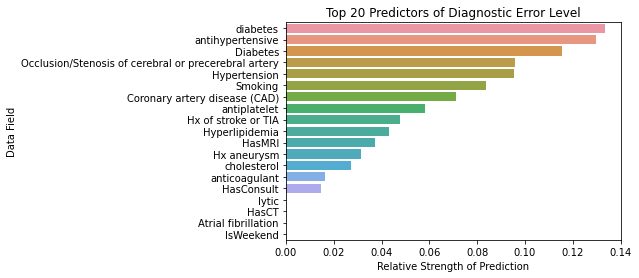

In [135]:
# create figure variables
rf_importances_20_fig, rf_importances_20_axes = plt.subplots()

temp_data = rf_importances.head(20)['Feature Importance']
sns.barplot(y=temp_data.index, x=temp_data.values, ax=rf_importances_20_axes)

# set text
rf_importances_20_axes.set_title('Top 20 Predictors of Diagnostic Error Level')
rf_importances_20_axes.set_ylabel('Data Field')
rf_importances_20_axes.set_xlabel('Relative Strength of Prediction')

In [73]:
def rescale(df, cols):
    new_df = df.copy()
    for c in cols:
        new_df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1,1))
    return new_df

In [81]:
s_feature_vec = rescale(feature_vec, X_cols)
s_labeled_df, s_unlabeled_df, _, _ = util.makeDataset(s_feature_vec, label_df)
sX_train, sX_test, sy_train, sy_test = train_test_split(s_labeled_df[X_cols], s_labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

In [ ]:
display(s_feature_vec)

In [ ]:
s_labeled_df

In [84]:
sX_train

,Hypertension,Hyperlipidemia,Diabetes,Hx of stroke or TIA,Hx aneurysm,Occlusion/Stenosis of cerebral or precerebral artery,Coronary artery disease (CAD),Smoking,Atrial fibrillation,anticoagulant,lytic,antiplatelet,antihypertensive,cholesterol,diabetes,HasConsult,HasCT,HasMRI,IsWeekend
7,0.052632,0.013333,0.002817,0.000000,0.000000,0.0,0.013158,0.00,0.0,0.0,0.0,0.000000,0.006627,0.006135,0.000000,0.0,0.0,0.0,0.0
47,0.263158,0.560000,0.000000,0.321429,0.000000,0.0,0.013158,0.22,0.0,0.0,0.0,0.000000,0.120029,0.361963,0.000000,0.0,1.0,0.0,0.0
62,0.046784,0.013333,0.129577,0.000000,0.000000,0.0,0.052632,0.00,0.0,0.0,0.0,0.102041,0.459499,0.599182,0.275758,0.0,0.0,0.0,0.0
98,0.187135,0.000000,0.121127,0.000000,0.000000,0.0,0.013158,0.00,0.0,0.0,0.0,0.000000,0.686303,0.000000,0.066667,0.0,1.0,0.0,1.0
133,0.076023,0.026667,0.000000,0.000000,0.000000,0.0,0.039474,0.00,0.0,0.0,0.0,0.000000,0.525037,0.366053,0.000000,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.040936,0.080000,0.011268,0.000000,0.000000,0.0,0.000000,0.02,0.0,0.0,0.0,0.000000,0.330633,0.337423,0.329293,0.0,1.0,0.0,0.0
139,0.245614,0.133333,0.019718,0.014286,0.000000,0.0,0.059211,0.00,0.0,0.0,0.0,0.000000,0.164212,0.368098,0.000000,0.0,0.0,0.0,0.0
31,0.064327,0.146667,0.022535,0.000000,0.000000,0.0,0.065789,0.00,0.0,0.0,0.0,0.000000,0.322533,0.000000,0.366667,0.0,1.0,0.0,0.0
174,0.023392,0.213333,0.008451,0.000000,0.056738,0.0,0.098684,0.00,0.0,0.0,0.0,0.000000,0.411635,0.411043,0.000000,0.0,0.0,0.0,0.0


In [97]:
s_estimator_log = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')
s_hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-5, 5, 100)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True]
}
s_grid_search_log = GridSearchCV(
    estimator = s_estimator_log
    ,param_grid = s_hyperparameter_grid_log
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

s_best_model_log = s_grid_search_log.fit(sX_train, sy_train)

In [98]:
eval_model(s_best_model_log, sX_test, sy_test)
eval_model(s_best_model_log, sX_train, sy_train)

[[8 0]
 [7 0]]
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70         8
         1.0       0.00      0.00      0.00         7

    accuracy                           0.53        15
   macro avg       0.27      0.50      0.35        15
weighted avg       0.28      0.53      0.37        15

[[36  0]
 [43  0]]
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        36
         1.0       0.00      0.00      0.00        43

    accuracy                           0.46        79
   macro avg       0.23      0.50      0.31        79
weighted avg       0.21      0.46      0.29        79



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
cohort_df = datasubset["cohort"]

In [139]:
cohort_df[['patientSSN', "AdmitDateTime"]].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [ ]:
util.makeIndexVec(cohort_df)

In [153]:
demo_df = datasubset["Demorgraphics"]

In [ ]:
util.makeAgeVec(demo_df)

In [ ]:
temp = util.makeAgeVec(demo_df)
MinMaxScaler().fit_transform(temp.iloc[:,:])

In [240]:
conn = pyodbc.connect("DRIVER={SQL Server};SERVER=VHACDWRB03;DATABASE=ORD_Singh_201911038D")
note_df = pd.read_sql(sql="select * from Dflt._B00_ML4TrgPos_Y201621_30_Note t", con=conn)

In [243]:
display(note_df.TIUStandardTitle.value_counts())

ADDENDUM                                                   263658
NURSING NOTE                                                91590
NURSING INPATIENT NOTE                                      39537
ADMINISTRATIVE NOTE                                         30790
EMERGENCY DEPT NOTE                                         21714
                                                            ...  
VISION REHABILITATION CONSULT                                   1
DENTISTRY C & P EXAMINATION CONSULT                             1
CARDIOLOGY CRITICAL CARE UNIT ADMISSION EVALUATION NOTE         1
PHYSICAL THERAPY OUTPATIENT E & M CONSULT                       1
OTOLARYNGOLOGY INPATIENT CONSULT                                1
Name: TIUStandardTitle, Length: 2402, dtype: int64

In [ ]:
note_df[note_df.TIUStandardTitle.str.contains("triage", case=False)]

In [ ]:
triage_df = note_df[note_df["TIUStandardTitle"]=="EMERGENCY DEPT TRIAGE NOTE"]
display(triage_df)

In [ ]:
triage_df[triage_df.PatientSSN == "000000000000000"].iloc[0].ReportText

In [ ]:
triage_df[triage_df.PatientSSN == "000000000000000"].iloc[0].ReportText

In [ ]:
triage_df[triage_df.PatientSSN == "000000000000000"]

In [ ]:
note_df[note_df.PatientSSN == "000000000000000"]

In [ ]:
cohort_df[cohort_df.patientSSN == 000000000000000]